In [5]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from attention import Attention
import numpy as np
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import konlpy
import nltk

In [6]:
# 데이터 불러오기
df = pd.read_csv('train_data.csv')
df = df.drop(['index'], axis=1)
df.head()

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [7]:
def clean_ko(df):
    # 첫 번째 칼럼의 이름을 가져옵니다.
    column_name = df.columns[0]

    # 텍스트 정제 (HTML 태그 제거)
    df[column_name] = df[column_name].apply(lambda x: BeautifulSoup(x, 'html.parser').text)

    # 텍스트 정제 (특수기호 제거)
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x))

    # 텍스트 정제 (형태소 분석)
    okt = konlpy.tag.Okt()
    def tokenize(text):
        return ' '.join([word[0] for word in okt.pos(text, stem=True) if word[1] in ['Noun', 'Verb', 'Adjective']])
    df[column_name] = df[column_name].apply(tokenize)

    # 텍스트 정제 (불용어 제거)
    nltk.download('punkt')
    stopwords_url = 'https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt'
    stopwords = pd.read_csv(stopwords_url, header=None)[0].apply(lambda x: x.strip()).to_list()
    df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in nltk.tokenize.word_tokenize(x) if word not in stopwords]))

    return df

In [8]:
# 데이터 중복 처리
df.drop_duplicates(subset=['title'], inplace=True)

df = clean_ko(df)
# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['title'])
sequences = tokenizer.texts_to_sequences(df['title'])

# 패딩 (모든 시퀀스를 동일한 길이로 만듦)
max_sequence_length = max([len(seq) for seq in sequences])
data = pad_sequences(sequences, maxlen=max_sequence_length)

# 레이블을 원-핫 인코딩
labels = to_categorical(df['topic_idx'])

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jiwoossong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# LSTM 모델 구축
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(labels.shape[1], activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# 모델 요약 출력
model.summary()

2023-11-17 21:06:52.634171: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-17 21:06:52.634195: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-17 21:06:52.634199: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-17 21:06:52.634610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-17 21:06:52.634974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           2650300   
                                                                 
 dropout (Dropout)           (None, 15, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 15, 128)           117248    
                                                                 
 attention (Attention)       (None, 128)               49152     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 2817603 (10.75 MB)
Trainable params: 28176

In [10]:
# 모델 학습
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping_callback])
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/100


2023-11-17 21:06:55.641641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-17 21:06:55.705869: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-17 21:06:56.420585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-17 21:06:59.475444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1142/1142 [==============================] - ETA: 0s - loss: 0.8367 - accuracy: 0.7045

2023-11-17 21:08:25.716593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-17 21:08:25.737857: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-17 21:08:25.926438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1142/1142 [==============================] - 107s 88ms/step - loss: 0.8367 - accuracy: 0.7045 - val_loss: 0.5309 - val_accuracy: 0.8212
Epoch 2/100
1142/1142 [==============================] - 85s 75ms/step - loss: 0.3896 - accuracy: 0.8711 - val_loss: 0.5061 - val_accuracy: 0.8331
Epoch 3/100
1142/1142 [==============================] - 84s 74ms/step - loss: 0.2634 - accuracy: 0.9139 - val_loss: 0.5435 - val_accuracy: 0.8256
Epoch 4/100
1142/1142 [==============================] - 84s 74ms/step - loss: 0.1927 - accuracy: 0.9350 - val_loss: 0.6072 - val_accuracy: 0.8164
Epoch 5/100
1142/1142 [==============================] - 83s 73ms/step - loss: 0.1464 - accuracy: 0.9514 - val_loss: 0.6626 - val_accuracy: 0.8117
Epoch 6/100
1142/1142 [==============================] - 83s 73ms/step - loss: 0.1200 - accuracy: 0.9593 - val_loss: 0.7288 - val_accuracy: 0.8102
Epoch 7/100
1142/1142 [==============================] - 84s 73ms/step - loss: 0.0960 - accuracy: 0.9677 - val_loss: 0.7442 - val

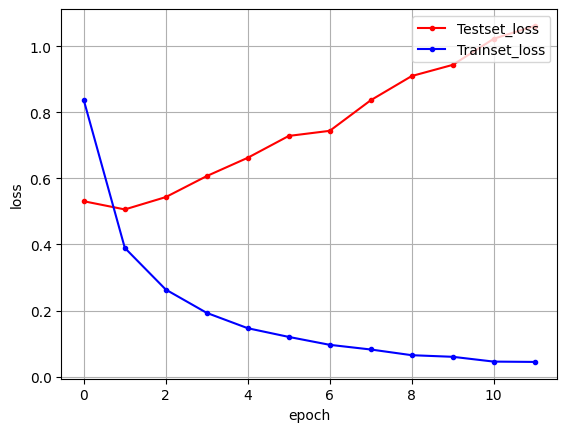

In [11]:
# 학습셋과 테스트셋의 오차를 저장 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [13]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

label = ['IT/과학', '경제', '사회', '생활/문화', '세계', '스포츠', '정치']
predict_label = []

# 새로운 데이터 파일 경로
new_data_file_path = 'newsdata.csv'

# 새로운 데이터 불러오기
new_df = pd.read_csv(new_data_file_path)

# 새로운 데이터의 'title' 컬럼에 대한 시퀀스 생성
new_sequences = tokenizer.texts_to_sequences(new_df['title'])
new_data = pad_sequences(new_sequences, maxlen=max_sequence_length)

# 모델을 사용하여 카테고리 예측
predicted_categories = model.predict(new_data)
predicted_category_indices = np.argmax(predicted_categories, axis=1)

# 예측된 카테고리 인덱스를 실제 카테고리 이름으로 변환
for i in range(len(predicted_category_indices)):
    predict_label.append(label[predicted_category_indices[i]])

# 예측 결과를 데이터프레임에 추가
new_df['category'] = predict_label


2/2 [==============================] - 0s 9ms/step


In [14]:
new_df.head()

,title,link,comments,category
0,"""공매도 효과 '의문'…에코프로비엠 숏커버링 약해""",https://n.news.naver.com/article/215/000113440...,['기래기야 아침 뉴스에 공매제도 개선할때까지 공매 금지시기겠다고 나와서 똥줄타나?...,경제
1,금감원장 “공매도 금지 따른 시장 불안 조성 행위 엄중 단속”,https://n.news.naver.com/article/215/000113444...,"['공매도 전산화나 하세요.', '그런데 김주현은 공매도부패카르텔의 뒷배같아! 제대...",사회
2,'매물 사라지고 가격 폭등'…전세대란 예고,https://n.news.naver.com/article/215/000113431...,['폭락 막을라고 아주 애를 쓰는구나ㅋㅋ 매물 거둬들이고 전세값 올려도 영끌이들은 ...,IT/과학
3,"청년 41만명 ""그냥 쉬어요""…정부, 니트족 돕는 ‘1조’ 대책 내놨다",https://n.news.naver.com/article/215/000113445...,['놀고 먹는애들을 왜 도와주는건가.힘든일은 하기 싫고 눈만 높은애들이 태반일텐데....,경제
4,"""돈은 마음대로 내세요""…빵집 실험결과는",https://n.news.naver.com/article/215/000113433...,"['프랑스보다 GDP낮은 우리나라 바게트는 1개 4,500원 프랑스는 2,000원 ...",IT/과학


In [15]:
# 특정 카테고리만 출력
sp_titles = new_df[new_df['category'] == '사회'] # 출력하고싶은 카테고리 입력

In [16]:
# 자신의 PC에 맞는 폰트 지정
import matplotlib.pyplot as plt
# 윈도우에서 한글 폰트 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'

# 맥OS에서 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

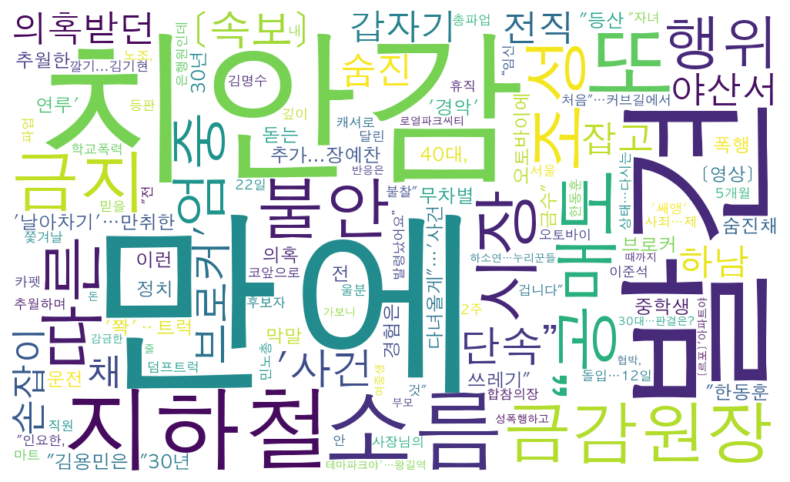

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd


# 모든 내용을 하나의 문자열로 합치기
text = ' '.join(sp_titles['title'])

# 단어의 빈도수 계산
words = text.split()
count = Counter(words)
data = dict(count)

# 윈도우
# font_path = 'C:/Windows/Fonts/malgun.ttf' 
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

# 워드클라우드 객체 생성
wc = WordCloud(font_path=font_path, background_color="white", width=1000, height=600)
wc_img = wc.generate_from_frequencies(data)

# 워드클라우드 이미지 표시
plt.figure(figsize=(10, 6))
plt.imshow(wc_img, interpolation='bilinear')
plt.axis('off')
plt.show()